<a id='section_id'></a>

# Отток клиентов банка

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv("/datasets/Churn.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


Сразу видим, что названия столбцов необходимо преобразовать, поскольку в их именах строчные буквы сочетаются с прописными.

In [3]:
df.columns = df.columns.str.lower()
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

In [4]:
df.columns = ['row_number', 'customer_id','surname', 'credit_score', 'geography', 'gender',
                   'age', 'tenure', 'balance', 'number_of_products', 'has_credit_card',
                   'is_active_member', 'estimated_salary', 'exited']

In [5]:
#оценим общий массив данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   row_number          10000 non-null  int64  
 1   customer_id         10000 non-null  int64  
 2   surname             10000 non-null  object 
 3   credit_score        10000 non-null  int64  
 4   geography           10000 non-null  object 
 5   gender              10000 non-null  object 
 6   age                 10000 non-null  int64  
 7   tenure              9091 non-null   float64
 8   balance             10000 non-null  float64
 9   number_of_products  10000 non-null  int64  
 10  has_credit_card     10000 non-null  int64  
 11  is_active_member    10000 non-null  int64  
 12  estimated_salary    10000 non-null  float64
 13  exited              10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Таблица имеет 10000 строк и 14 столбцов. Видим пропущенные значения только одном столбце tenure. **Восстановить пропуски невозможно, поэтому их лучше всего удалить (доля пропусков менее 10%).** 
В массиве представлены как категориальные (surname, geography, gender), так и количественные признаки. Для столбца tenure треубуется заменить тип данных с float на int, поскольку данные принимают только целочисленное значение.

In [6]:
#проверим наличие явных дубликатов
df.duplicated().sum()

0

In [7]:
#исследуем данные на наличие выбросов
df.describe().T

,count,mean,std,min,25%,50%,75%,max
row_number,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
customer_id,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
credit_score,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
number_of_products,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
has_credit_card,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
is_active_member,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48


На первый взгляд мы не видим каких-либо серьезных выбросов. Например, минимальный возраст 18 лет, а максимальный 92, что вполне может быть правдой. Немного смущает минимальная зарплата на уровне 11.58. Построим ящик с усами для признака estimated_salary.

(-10000.0, 250000.0)

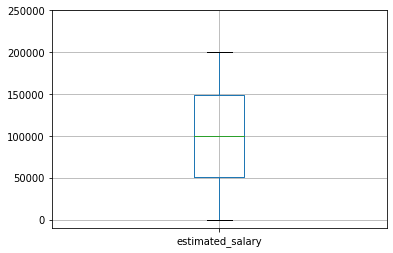

In [8]:
df.boxplot(column='estimated_salary')
plt.ylim(-10000, 250000)

В размах «усов» попадают нормальные значения, а за пределами находятся выбросы. Таким образом, необходимости удалять строки с небольшими зарплатами нет.

Из представленных категориальных признаков нам могут быть интересны два: gender и geography. Посмотрим в разрезе двух этих признаков на всю выборку целиком и выборку положительных объектов ('exited' == 1).

In [9]:
df_target_ones = df.query('exited == 1')
display("Общая выборка", df['gender'].value_counts(normalize=True))
display("Положительная выборка", df_target_ones['gender'].value_counts(normalize=True))
display("Общая выборка", df['geography'].value_counts(normalize=True))
display("Положительная выборка", df_target_ones['geography'].value_counts(normalize=True))

'Общая выборка'

Male      0.5457
Female    0.4543
Name: gender, dtype: float64

'Положительная выборка'

Female    0.559156
Male      0.440844
Name: gender, dtype: float64

'Общая выборка'

France     0.5014
Germany    0.2509
Spain      0.2477
Name: geography, dtype: float64

'Положительная выборка'

Germany    0.399607
France     0.397644
Spain      0.202749
Name: geography, dtype: float64

Мы видим, что в общей выборке мужчин больше чем женщин (55% vs 45%), а в положительной выборке пропорция сохранилась, только большинством уже стали женщины. Что касается стран, то здесь выделяется Германия, которая в общей выборке представляет 25% строк, а в положительной выборке уже почти 40%. Все это говорит нам, что оба признака могут влиять на обучение модели и их нужно оставить, преобразовав в количественные с помощью OHE. **Столбцы row_number, customer_id и surname мы можем удалить, поскольку они не несут полезной нагрузки.**

In [10]:
df = df.drop(['row_number', 'customer_id', 'surname'], axis=1)
#значения в столбце gender сильно связаны между собой, для избежания дамми-ловушки можно выбросить первый столбец. 
df["gender"] = pd.get_dummies(df["gender"],drop_first=True)
#опытным путем было получено, что отбрасывание первого столбца при кодировании столбца geography ухудшает показатели метрик
df = pd.get_dummies(df)
df.head()

,credit_score,gender,age,tenure,balance,number_of_products,has_credit_card,is_active_member,estimated_salary,exited,geography_France,geography_Germany,geography_Spain
0,619,0,42,2.0,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,39,1.0,0.00,2,0,0,93826.63,0,1,0,0
4,850,0,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


Перед преобразованием типа данных в столбце tenure сначала заменим пропуски на медианное значение.

In [11]:
df = df.dropna(subset = ['tenure'])
#df['tenure'] = df['tenure'].fillna(df['tenure'].median()) - заполнение пропусков медианой имеет меньшие значения f1
df['tenure'] = df['tenure'].astype("int")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   credit_score        9091 non-null   int64  
 1   gender              9091 non-null   uint8  
 2   age                 9091 non-null   int64  
 3   tenure              9091 non-null   int64  
 4   balance             9091 non-null   float64
 5   number_of_products  9091 non-null   int64  
 6   has_credit_card     9091 non-null   int64  
 7   is_active_member    9091 non-null   int64  
 8   estimated_salary    9091 non-null   float64
 9   exited              9091 non-null   int64  
 10  geography_France    9091 non-null   uint8  
 11  geography_Germany   9091 non-null   uint8  
 12  geography_Spain     9091 non-null   uint8  
dtypes: float64(2), int64(7), uint8(4)
memory usage: 745.7 KB


**Данные подготовлены к дальнейшему анализу: столбцы перименованы, удалены лишние признаки, необходимые для анализа признаки имеют количественные значения, пропуски отсутствуют.**

## Исследование задачи

Проверим сбалансированность выборки по целевому признаку - как часто в целевом признаке встречается класс «1» или «0».

In [12]:
df["exited"].value_counts(normalize=True)

0    0.796062
1    0.203938
Name: exited, dtype: float64

Доля ушедших клиентов составляет всего 20% от общей выборки. Налицо несбалансированность данных. Сначала построим модели без учета дисбаланса, а затем попробуем разные инструменты для нивелирования дисбаланса и сравним полученные F1-метрику и AUC-ROC метрики. 

Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные пошагово разобьем в соотношении 3:1:1.

In [13]:
df_train, df_middle = train_test_split(df, test_size=0.4, random_state=12345)
print("Обучающая выборка:", df_train.shape)
print("Валидационная и тестовая выборки:",df_middle.shape)

Обучающая выборка: (5454, 13)
Валидационная и тестовая выборки: (3637, 13)


In [14]:
df_valid, df_test = train_test_split(df_middle, test_size=0.5, random_state=12345)
print("Валидационная выборка:",df_valid.shape)
print("Тестовая выборка:",df_test.shape)
#, stratify=df_middle["exited"]

Валидационная выборка: (1818, 13)
Тестовая выборка: (1819, 13)


In [15]:
#объявим переменные с признаками и целевым признаком для каждой из полученных выборок
features_train = df_train.drop(["exited"], axis = 1)
target_train = df_train["exited"]
features_valid = df_valid.drop(["exited"], axis = 1)
target_valid = df_valid["exited"]
features_test = df_test.drop(["exited"], axis = 1)
target_test = df_test["exited"]

In [16]:
#сначала обучим модель с помощью алгоритма решающего дерева, варьируя гиперпараметр "Максимальная глубина"
best_result = 0
for depth in range(1, 11):
    model_1 = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_1.fit(features_train, target_train)
    predicted_valid = model_1.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model_1.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc= roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result:
        best_result = result
        best_depth = depth        
print("F1-мера наилучшей модели на валидационной выборке:", best_result, "Максимальная глубина:", 
      best_depth, "AUC-ROC:", auc_roc)

F1-мера наилучшей модели на валидационной выборке: 0.5735449735449736 Максимальная глубина: 5 AUC-ROC: 0.7304701089907722


In [17]:
#теперь построим модель с помощью алгоритма случайного леса, изменяя гиперпараметры "Количество деревьев" и "Максимальная глубина"
best_result = 0
for est in range(10, 101, 10):
    for depth in range (1, 21):
        model_2 = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model_2.fit(features_train, target_train) 
        predicted_valid = model_2.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        probabilities_valid = model_2.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc= roc_auc_score(target_valid, probabilities_one_valid)
        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth
print("F1-мера наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:",best_est, "Максимальная глубина:", best_depth,"AUC-ROC:", auc_roc)

F1-мера наилучшей модели на валидационной выборке: 0.6606683804627249 Количество деревьев: 80 Максимальная глубина: 9 AUC-ROC: 0.8613510732489411


In [18]:
#справочно: пробую подбирать оптимальные параметры для валидационной выборки с помощью GridSearchCV(), 
#предварительно обучив модель на обучающей выборке
parametrs = { 'n_estimators': range (10, 101, 10),
              'max_depth': range (1, 21)}
model_gs = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_gs.fit(features_train, target_train) 
grid = GridSearchCV(model_gs, parametrs)
grid.fit(features_valid, target_valid)
grid.best_params_

{'max_depth': 13, 'n_estimators': 80}

In [19]:
#наконец построим модель с помощью логистической регрессии
model_3 = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100, class_weight='balanced') 
model_3.fit(features_train, target_train)
predicted_valid = model_3.predict(features_valid)
result = f1_score(target_valid, predicted_valid)
probabilities_valid = model_3.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc= roc_auc_score(target_valid, probabilities_one_valid)
print("F1-мера на валидационной выборке:", result,"AUC-ROC:", auc_roc)

F1-мера на валидационной выборке: 0.3595667870036101 AUC-ROC: 0.5856749199734197


Мы видим, что наибольшое значение F1-меры на валидационной выборке (66%) нам дала модель, построенная с помощью алгоритма случайный лес со следующими гиперпараметрами: количество деревьев: 80, максимальная глубина: 9. Модель дерева решений с максимальной глубиной 5 дала F1 на уровне 57%. Наименьшую точность показала модель логистической регрессии - всего 36%.

## Борьба с дисбалансом

In [20]:
#cтандартизируем численные признаки
numeric =  ['credit_score','gender', 'age', 'tenure', 'balance',
       'number_of_products', 'has_credit_card', 'is_active_member',
       'estimated_salary', 'geography_Germany',
       'geography_Spain','geography_France']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
pd.options.mode.chained_assignment = None

In [21]:
#разделим обучающую выборку на отрицательные и положительные объекты
features_zeros = features_train[target_train == 0] 
features_ones = features_train[target_train == 1] 
target_zeros = target_train[target_train == 0] 
target_ones = target_train[target_train == 1] 

In [22]:
#продублируем объекты положительного класса и объединим их с объектами отрицательного класса
#для этого обучим выбранную модель, варьируя параметр repeat
best_result = 0
for repeat in np.arange(2, 21):
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    model_us = RandomForestClassifier(random_state=12345, n_estimators=80, max_depth=9, class_weight='balanced')
    model_us.fit(features_upsampled, target_upsampled)
    predicted_valid = model_us.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model_us.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc= roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result:
        best_result = result
        best_repeat = repeat
print("F1-мера наилучшей модели на валидационной выборке:", best_result, "Repeat:", best_repeat,"AUC-ROC:", auc_roc)

F1-мера наилучшей модели на валидационной выборке: 0.640552995391705 Repeat: 10 AUC-ROC: 0.8716574291725647


При использовании upsampling F1-мера уменьшилась на 2% с 66% до 64%.
Теперь попробуем уменьшить отрицательную выборку.

In [23]:
#случайным образом отбросим часть из отрицательных объектов и объединим их с объектами положительного класса
#для этого обучим выбранную модель, варьируя параметр fraction
best_result = 0
for fraction in np.arange(0.1, 1, 0.05):
    features_downsampled =  pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    model_ds = RandomForestClassifier(random_state=12345, n_estimators=80, max_depth=9, class_weight='balanced')
    model_ds.fit(features_downsampled, target_downsampled)
    predicted_valid = model_ds.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model_ds.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc= roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result:
        best_result = result
        best_fraction = fraction
print("F1-мера наилучшей модели на валидационной выборке:", best_result, "Fraction:", best_fraction,"AUC-ROC:", auc_roc)

F1-мера наилучшей модели на валидационной выборке: 0.6472819216182047 Fraction: 0.9500000000000003 AUC-ROC: 0.8723108952116585


При downsampling F1-мера уменьшилась на 1,3% с 66% до 64,7%.

**Таким образом, ни upsampling, ни downsampling не привели к улучшению результата, поэтому в дальнейшем использоваться не будут**

In [24]:
#проверим, как влияет изменение порога классификации
best_result = 0
model_th= RandomForestClassifier(random_state=12345, n_estimators=80, max_depth=9, class_weight='balanced')
model_th.fit(features_train, target_train) 
predicted_valid = model_th.predict(features_valid)
for threshold in np.arange(0, 1, 0.02):
    predicted_valid = model_th.predict(features_valid)
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model_th.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1] 
    predicted_valid = probabilities_one_valid > threshold
    result = f1_score(target_valid, predicted_valid)
    probabilities_valid = model_th.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc= roc_auc_score(target_valid, probabilities_one_valid)
    if result > best_result:
        best_result = result
        best_threshold = threshold
print("F1-мера наилучшей модели на валидационной выборке:", best_result, "Threshold:", best_threshold,"AUC-ROC:", auc_roc)

F1-мера наилучшей модели на валидационной выборке: 0.6606683804627249 Threshold: 0.5 AUC-ROC: 0.8723293027057176


**Изменять порог классификации также нет необходимости**

**Таким образом, наилучший результат продемонстировала модель и выборка со следующими параметрами:**
 - модель случайного леса, количество деревьев: 80, максимальная глубина: 9
 - сбалансированные классы
 - upsampling или downsampling не требуются
 - порог классификации: 0.5

## Тестирование модели

In [25]:
#проверим итоговую модель на тестовой выборке
model_final = RandomForestClassifier(random_state=12345, n_estimators=80, max_depth=9, class_weight='balanced')
model_final.fit(features_train, target_train) 
predicted_test = model_final.predict(features_test)
result = f1_score(target_test, predicted_test)
print("F1-мера на тестовой выборке:", result)
probabilities_test = model_final.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_test)
print("AUC-ROC на тестовой выборке:", roc_auc)

F1-мера на тестовой выборке: 0.6185286103542235
AUC-ROC на тестовой выборке: 0.8579457680275119


In [26]:
#построим матрицу ошибок и выведем основные показатели классификации
#print(confusion_matrix(target_test, model_final.predict_proba(features_test), normalize='true')
display(confusion_matrix(target_test, model_final.predict(features_test), normalize='true'))
print(classification_report(target_test, model_final.predict(features_test), target_names=['0', '1']))

array([[0.89373297, 0.10626703],
       [0.35327635, 0.64672365]])

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1468
           1       0.59      0.65      0.62       351

    accuracy                           0.85      1819
   macro avg       0.75      0.77      0.76      1819
weighted avg       0.85      0.85      0.85      1819



**На основании матрицы ошибок мы видим, что выбранная нами модель на 45% лучше в предсказании ухода клиента, чем константная модель. Полученный результат на тестовой выборке F1-меры равен 0.62, что превышает необходимый уровень 0.59.** 

In [27]:
#посмотрим, какие топ-5 факторов оказывают наибольшее влияние на нашу модель 
fi = pd.DataFrame({'name':features_test.columns,'fi':model_final.feature_importances_})
fi.sort_values('fi',ascending=False).reset_index(drop=True).head()

,name,fi
0,age,0.331386
1,number_of_products,0.196469
2,balance,0.116087
3,estimated_salary,0.081185
4,credit_score,0.078311


**Наиболее значимыми признаками стали возраст (33%), количество продуктов в банке (20%) и баланс на счете (12%).**